## <a id="Top" style="color:black;">Top</a>
- [Plotting BH evaporation](#BHevap)
- [Fitting the Lightcurves of GRB candidates](#lightcurves)
- [Expanding to other sources](#candidates)
- [Batch fit all sources with a GBM or LLE t90 less than 2s](#batchfit2s)

In [23]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import ultranest
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, norm

from threeML import *

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

from threeML.io.package_data import get_path_of_data_file

import warnings
warnings.simplefilter("ignore")

In [4]:
# EBH Plotting
def afterglow(tau, delta, t_m, t_p, normalization):
    """
    Afterglow model.
    """
    # lifetime only, no spectrum.
    # Norm * \frac{e^{(-t -\Delta)/tp } }{1 - e^{(-t - \Delta)/tm} }
    return normalization* ( 
        np.exp(-(1/t_p)*(tau - delta)) /
        (1 + np.exp(-(1/t_m)*(tau - delta))) )

# Simplifying lightcurve with powerlaw of index -.52
def simplified_lightcurve(tau, normalization = 1., index = .52, delta=0):
    """
    Simplified lightcurve model.

    Form 
    """
    f = normalization*(-tau + delta)**(-index)
    for i, val in enumerate(f):
        if np.isnan(val) or np.isinf(val):
            break
    f[i:] = 0
    return f

### <a id="BHevap" style="color:black;">Plotting BH evaporation</a>
[back to top](#Top)

In [3]:
#GBM Energy Spectrum
Emin = 50*10**(-6) # GeV
Emax = 300*10**(-6) # GeV

"""
def afterglow(tau, delta, t_m, t_p, normalization):
    """
    #Afterglow model.
    """
    # lifetime only, no spectrum.
    # Norm * \frac{e^{(-t -\Delta)/tp } }{1 - e^{(-t - \Delta)/tm} }
    return normalization* ( 
        np.exp(-(1/t_p)*(tau - delta)) /
        (1 + np.exp(-(1/t_m)*(tau - delta))) )

# Simplifying lightcurve with powerlaw of index -.52
def simplified_lightcurve(tau, normalization = 1., index = .52, delta=0):
    """
    #Simplified lightcurve model.

    #Form 
    """
    f = normalization*(-tau + delta)**(-index)
    for i, val in enumerate(f):
        if np.isnan(val) or np.isinf(val):
            break
    f[i:] = 0
    return f
"""

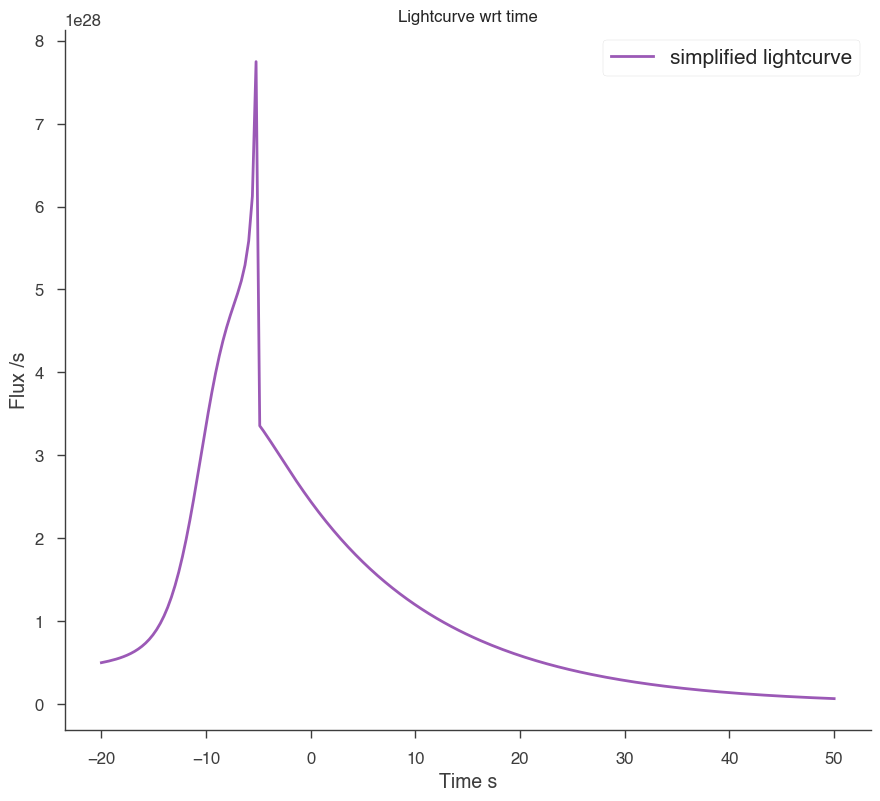

In [63]:
tau = np.linspace(-20,50,200)

curve = np.zeros(200)

fig, ax = plt.subplots()

curve = curve + simplified_lightcurve(tau, normalization = 2*1e28, delta = -5)

curve = curve + afterglow(tau, -10, 1.5, 14, 5*1e28)

ax.plot(tau, curve, label = 'simplified lightcurve')

#ax.set_xlim(30,-30)

ax.set_xlabel("Time s")
ax.set_ylabel("Flux /s")
ax.set_title("Lightcurve wrt time")
ax.legend(prop={'size':15})
plt.show()

### <a id="lightcurves" style="color:black;">Fitting the Lightcurves</a>
[back to top](#Top)

In [ ]:
gbm_catalog = FermiGBMBurstCatalog()

In [4]:
def query_catalog(GRBNAME:str = '150902733', time_in = -30, time_out = 60, dt = .1, gbm_detectors = None):

    """
    Returns collection of figures (figures:list) and inputted gbm_detectors:list
    """
    
    # Check existence
    gbm_catalog.query_sources('GRB%s'%GRBNAME)

    # Pull info tab
    grb_info = gbm_catalog.get_detector_information()['GRB%s'%GRBNAME]
    
    # Is the mask in the tab?
    if gbm_detectors is None:
        gbm_detectors = grb_info["detectors"]
    print(gbm_detectors)

    # Pull source bounds
    source_interval = grb_info["source"]["fluence"]
    background_interval = grb_info["background"]["full"]

    # Download data
    dload = download_GBM_trigger_data('bn%s'%GRBNAME, detectors=gbm_detectors)

    fluence_plugins = []
    time_series = {}
    figures = []
    for det in gbm_detectors:

        ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
            det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
        )

        ts_cspec.set_background_interval(*background_interval.split(","))
        ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

        ts_tte = TimeSeriesBuilder.from_gbm_tte(
            det,
            tte_file=dload[det]["tte"],
            rsp_file=dload[det]["rsp"],
            restore_background=f"{det}_bkg.h5",
        )

        time_series[det] = ts_tte

        ts_tte.set_active_time_interval(source_interval)

        figures.append(ts_tte.view_lightcurve(time_in, time_out, dt = dt))
    
    return figures, gbm_detectors

import warnings
warnings.filterwarnings('ignore')

def get_curves(fig):
    """
    Takes in matplotlib figure object generated by query_catalog().

    Returns axes data as lists for x, curve and background
    """

    data = fig.get_axes()[0].get_lines()[0].get_xydata()
    x = data[:,0]
    curve = data[:,1]
    
    bckg_data = fig.get_axes()[0].get_lines()[1].get_xydata()
    bckg_data = bckg_data[:,1]
    
    return x, curve, bckg_data

def show_curves(figures, detectors:list = np.arange(12), save_csv=None):

    """
    Automates use of get_curves().

    Takes in gbm detectors to annotate figures and flag for whether to save data to csv.
    
    Returns figure with all detectors plotted.
    """

    figya, ax = plt.subplots()
    if save_csv is not None:
        assert type(save_csv) is str, 'Give a name to the file'
        assert detectors is not None, 'Just gimme the dets for cols'
        df = pd.DataFrame()
    for i,fig in enumerate(figures):
        x,curve, bckg = get_curves(fig)
        ax.plot(x,curve, label="det. %s"%detectors[i])
        ax.plot(x[0:-1],bckg, '--', label='bckg %s'%detectors[i])
        ax.legend(prop={'size':15})
        if save_csv is not None:
            df['time'] = x
            df[detectors[i]] = curve
            b = np.zeros(len(curve))
            b[0:len(bckg)] += bckg
            df['%s_bkg'%detectors[i]] = b
    if save_csv is not None:
        df.to_csv(save_csv)
    return figya

def retrieve_data(figures):
    """
    Legacy helper to subtract background from each detector & give the mean.
    """
    y = None
    for fig in figures:
        x, curve, bckg_data = get_curves(fig)
        if y is None:
            y = curve-np.mean(bckg_data)
        else:
            y+=(curve-np.mean(bckg_data))
    return y/len(figures), x

In [ ]:
# For example, 
figures,dets = query_catalog(dt=.1)
# Show.
fig = show_curves(figures,dets)
fig.show()

Building our model to fit the lightcurve requires a couple components.

Firstly, the model needs to have one value per second interval to match the lightcurves. This will occupy the interval of the signal onset.

Second, we will want an afterglow ~ inverse powerlaw. This will be the interval following, showing the decay of the signal. We could start this decay from the maximum from the previous interval, but I think it's better to leave it open for now.
[Afterglow]()

Lastly there will be a background which contributes to the model evenly.

In [9]:
# Assemble the data
data, time_domain = retrieve_data(figures)
# This data is the curve averaged over detectors - background. All we need is the model.

# We want this to base the EBH lifetime.
peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

# Data error 
error_tolerance = np.mean(data) * 0.001

In [7]:
import ultranest

param_names = ['K_lightcurve', 'K_powerlaw', 't_m_powerlaw', 't_p_powerlaw', 
               'delta_powerlaw', 'index_lightcurve'] 

def lightcurve_model(K_lightcurve=None, K_powerlaw=None, 
        t_m_powerlaw=None, t_p_powerlaw=None, 
                     delta_powerlaw=None, index_lightcurve=None,
                     energy_range = np.linspace(Emin, Emax, 1000)):
    
    # Blank model
    model = np.zeros(len(data))

    if K_lightcurve is not None:
        # Descending from len(peak) -> 0 
        tau = np.linspace(peak_index, 0, peak_index, endpoint=False)
        # Simplified powerlaw curve
        curve = lightcurve(tau=tau, energy_range=energy_range, normalization=K_lightcurve, index = index_lightcurve)
        # Applied to [0,peak]
        model[0:peak_index]=curve
    
    if K_powerlaw is not None: 
        # Afterglow curve
        afterglow_curve = afterglow(tau=time_domain, delta = delta_powerlaw, t_p = t_p_powerlaw, t_m = t_m_powerlaw, normalization=K_powerlaw)
        # Applied across entire domain
        model = model + afterglow_curve

    return model

def likelihood_model(params):
    K_lightcurve, K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw, index_lightcurve = params
    
    curve = lightcurve_model(K_lightcurve, K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw, index_lightcurve)
    
    like = -0.5 * (((curve - data)/error_tolerance)**2).sum()
    #like = pearsonr(data,curve)[0]
    return like

def likelihood_model_only_direct(params):
    K_lightcurve, index_lightcurve = params
    curve = lightcurve_model(K_lightcurve, None, None, None, None, index_lightcurve)
    return -0.5 * (((curve - data)/error_tolerance)**2).sum()
    
def likelihood_model_only_afterglow(params):
    K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw = params
    curve = lightcurve_model(None, K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw, None)
    return -0.5 * (((curve - data)/error_tolerance)**2).sum()

def prior_transform(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3#1e-26
    hi = 1e6#1e-24
    params[0] = cube[0] * (hi - lo) + lo

    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    
    # index_lightcurve: gaussian on -.52 
    params[5] = norm.ppf(cube[5], -.52, 1)
    
    return params

In [47]:
# Run fitting process
sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_transform)

result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+08  2e+08 [-2.234e+08..-2.234e+08]*| it/evals=34200/459327 eff=7.4522% N=400 
[ultranest] Likelihood function evaluations: 459327
[ultranest]   logZ = -2.234e+08 +- 0.229
[ultranest] Effective samples strategy satisfied (ESS = 2505.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.59, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.23 tail:0.01 total:0.23 required:<0.50
[ultranest] done iterating.

logZ = -223374814.038 +- 0.392
  single instance: logZ = -223374814.038 +- 0.225
  bootstrapped   : logZ = -223374814.090 +- 0.392
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: 28219 iterations

    K_lightcurve        3374.28 +- 0.36
    K_powerlaw          7604.41 +- 0.15
    t_m_powerlaw        1.261831 +- 0.000034
    t_p_powerlaw        2.31333 +- 0.00014
    delta_powerlaw      9.6

In [5]:
def plot_model(x, result = None, log=False, name='bn150902733', vals=None, fig_text = None):
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_figwidth(18)
    
    if result is not None:
        vals = result['posterior']['mean']
        std = result['posterior']['stdev']
    K_lightcurve = vals[0]
    K_powerlaw = vals[1]
    t_m_powerlaw = vals[2]
    t_p_powerlaw = vals[3]
    delta_powerlaw = vals[4]
    index_lightcurve = vals[5]
    
    ax1.scatter(x,data, s=30)
    ax2.scatter(x,data, s=30)
    
    fitted_model = lightcurve_model(K_lightcurve, K_powerlaw, t_m_powerlaw, t_p_powerlaw, delta_powerlaw, index_lightcurve)
    r = pearsonr(data,fitted_model)
    ax1.plot(x, 
            fitted_model,
            label = 'r:%.4e  pval:%.4e'%(r[0],r[1]))
    
    if K_lightcurve is not None:
        curve = lightcurve(tau=np.linspace(peak_index, 0, peak_index, endpoint=False), 
                                  energy_range=np.linspace(Emin, Emax, 1000), 
                                  normalization=K_lightcurve)
        ax2.plot(x[0:peak_index], curve, label = 'simplified direct+frag emission')
    if K_powerlaw is not None:
        afterglow_curve = afterglow(tau=time_domain, delta = delta_powerlaw, t_p = t_p_powerlaw, t_m = t_m_powerlaw, normalization=K_powerlaw)
        ax2.plot(x, afterglow_curve, '--', label = r'afterglow $\frac{e^{Ax}}{1-e^{Bx}}$', color='orange')

    #plt.ylim(100,200)
    #ax2.ylim(-3500,6500)
    ax1.legend(prop={'size': 15})
    ax2.legend(prop={'size': 15})
    ax1.set_ylabel('Count rate (per second, binned on .1s)')
    ax1.set_xlabel('Time wrt to trigger time')
    #ax2.set_ylabel('Count rate')
    ax2.set_xlabel('Time wrt to trigger time')
    fig.suptitle('Composite Bayesian fit of %s'%name, size=15)
    
    if fig_text is None:
        lc_txt="Lightcurve norm: %.4e +- %.2e & index: %.4f +- %.2f ; \n"%(vals[0], std[0], vals[5], std[5])
        pl_txt="Powerlaw norm: %.4e +- %.2e , t_m: %.4f +- %.2f , t_p: %.4f +- %.2f , delta: %.4f +- %.2f \n"%( 
            vals[1], std[1], vals[2], std[2], vals[3], std[3], vals[4], std[4] )
        fit_txt="logZ: %.4e +- %.2e (Z = marginal likelihood)"%(result['logz'], result['logzerr'])
        fig_text = lc_txt + pl_txt + fit_txt
    
    plt.figtext(0.5, 0.01, fig_text, wrap=True, horizontalalignment='center', fontsize=13)
    
    if log:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    return fig

#fig = plot_model(time_domain,result = result, log=False)


### <a id="dl_lc" style="color:black;">Downloading lightcurves</a>
[back to top](#Top)

In [5]:
def download_lightcurves(df, save_directory = './Selected_GRB_Images/Lightcurves/', dt=0.1):
    """
    Requires a dataframe with AT LEAST 'name', 'time_in', 'time_out', 'detectors'
    Select a save_directory for images/csvs and a time step (dt).

    Saves a figure and csv with stacked gbm_detector data for each.
    """
    # For each source,
    for i in range(0,len(df)):
        try:
            name = df.iloc[i]['name'][3:]
            t_i = df.iloc[i]['time_in']
            t_o = df.iloc[i]['time_out']
            dets = df.iloc[i]['detectors']
            print('Trying GRB%s on %s to %s'%(name, t_i, t_o))
            
            figures, dets = query_catalog(GRBNAME = name, time_in = t_i, time_out = t_o, dt = dt, gbm_detectors = dets)
            fig = show_curves(figures, detectors = dets, 
                              save_csv = '%sGRB%s_%s_to_%s_resolution_%s.csv'%(save_directory, name, t_i, t_o, dt))
            fig.savefig('%sGRB%s_%s_to_%s_resolution_%s.png'%(save_directory, name, t_i, t_o, dt), dpi=200)
            
        except Exception as e:
            print('Failed with %s'%df.iloc[i]['name'])
            print('%s\n'%e)

def merge_lightcurves( df:pd.DataFrame ):
    """
    Takes a dataframe as generated by show_curves(save_csv).

    Returns the 1D time, average of all detectors (data) and gbm detector names (detectors)
    """
    ## First col is time axis
    time = df.iloc[:,1][:-1]
    data = np.zeros(len(time))
    ## From there, we have each of the detectors and their associated background
    for i in range( 1, int((len(df.columns[2:])) / 2) ):
        
        data = data + df.iloc[:,(2*i)][:-1] - df.iloc[:,(2*i+1)][:-1] # Source - Fitted bkg
        
    data = data / len(df.columns[2:]) * 2 # Average all of the detectors used.
    
    return time, data, df.columns[2:]


In [6]:
df = pd.read_csv('./../GBM_Catalog_Searching/BOTH_T90_in_[0.2-5].csv')

df['detectors'] = [['n0','n1','n3','b0'],
                   ['n9','na','nb','b1'],
                   ['n6','n9','b1'], # omits na which has that awful bkg fit
                   ['n6','n7','n9', 'b1'],
                   ['n0','n1','n3','b0'],
                   ['n6','n7','n9','b1'],
                   ["n1","n2","n9","na","b0","b1"]]
df.to_csv('./../GBM_Catalog_Searching/BOTH_T90_in_[0.2-5].csv')

df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1.1,name,ra,dec,hardness,lle_t90,gbm_cat_t90,gbm-lle_t90_difference,time_in,time_out,detectors
0,0,0,0,0,0,0,0,0,0,2,25,GRB141222298,178.00,-57.31,inf,1.293,2.752,1.459,-20.0,50.0,"[n0, n1, n3, b0]"
1,1,1,1,1,1,1,1,1,1,16,85,GRB131014215,100.78,-20.76,1.224058,1.811,3.200,1.389,-30.0,50.0,"[n9, na, nb, b1]"
2,2,2,2,2,2,2,2,2,2,18,100,GRB140619475,132.66,-9.65,1.339559,1.124,2.816,1.692,-30.0,100.0,"[n6, n9, b1]"
3,3,3,3,3,3,3,3,3,3,21,121,GRB140102887,212.02,1.47,1.319773,2.872,3.648,0.776,-30.0,50.0,"[n6, n7, n9, b1]"
4,4,4,4,4,4,4,4,4,4,24,131,GRB140402007,207.66,5.97,9.669260,1.546,0.320,-1.226,-30.0,70.0,"[n0, n1, n3, b0]"
5,5,5,5,5,5,5,5,5,5,30,155,GRB081024891,323.01,20.84,1.916036,1.320,0.640,-0.680,-30.0,100.0,"[n6, n7, n9, b1]"
6,6,6,6,6,6,6,6,6,6,31,168,GRB190515190,137.75,28.93,1.454990,1.645,1.264,-0.381,-30.0,100.0,"[n1, n2, n9, na, b0, b1]"


Peak flux for GRB141222298 is 6270.548522042048
Peak flux for GRB131014215 is 32599.499398835058
Peak flux for GRB140619475 is 377.65851855940974
Peak flux for GRB140102887 is 4669.998040926421
Peak flux for GRB140402007 is 331.13345940010555
Peak flux for GRB081024891 is 391.5947872557576
Peak flux for GRB190515190 is 613.1671796615232


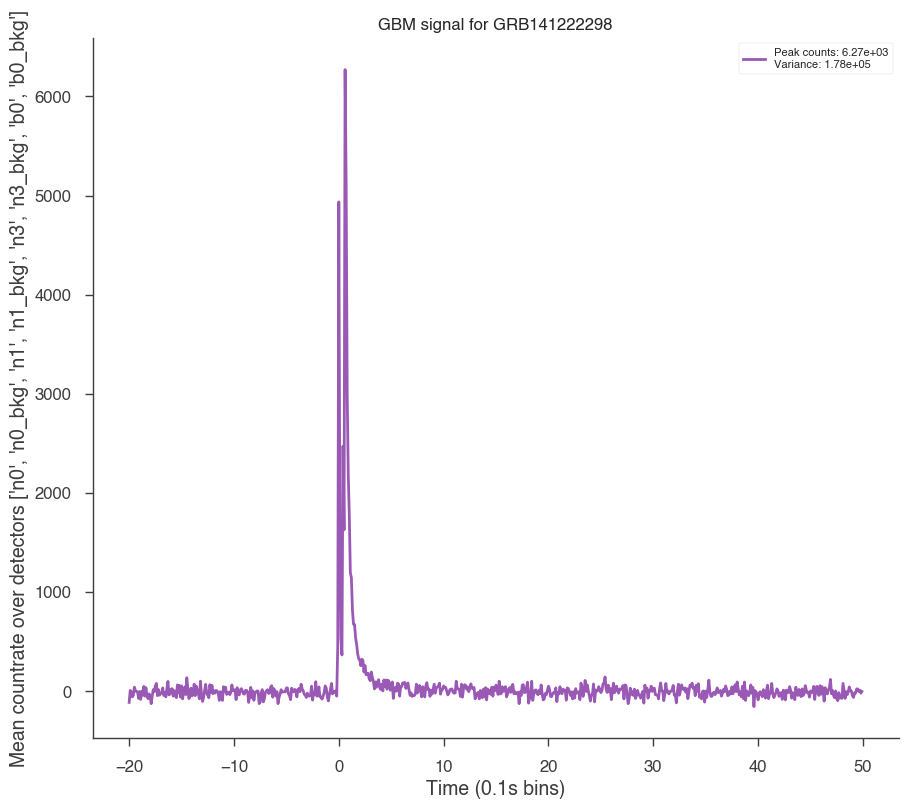

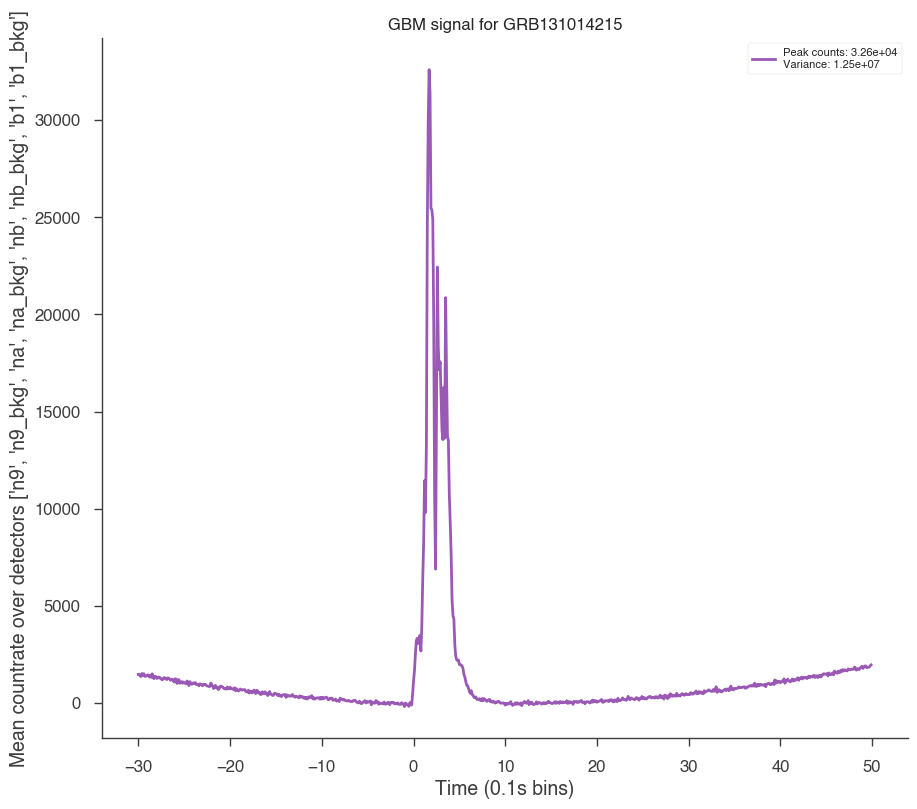

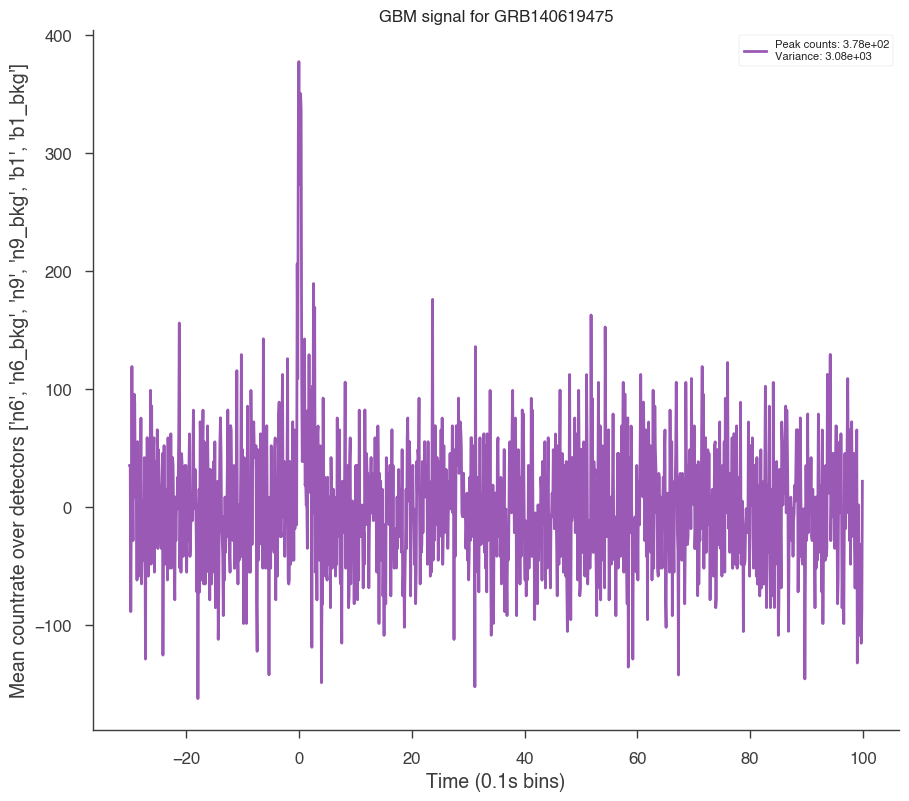

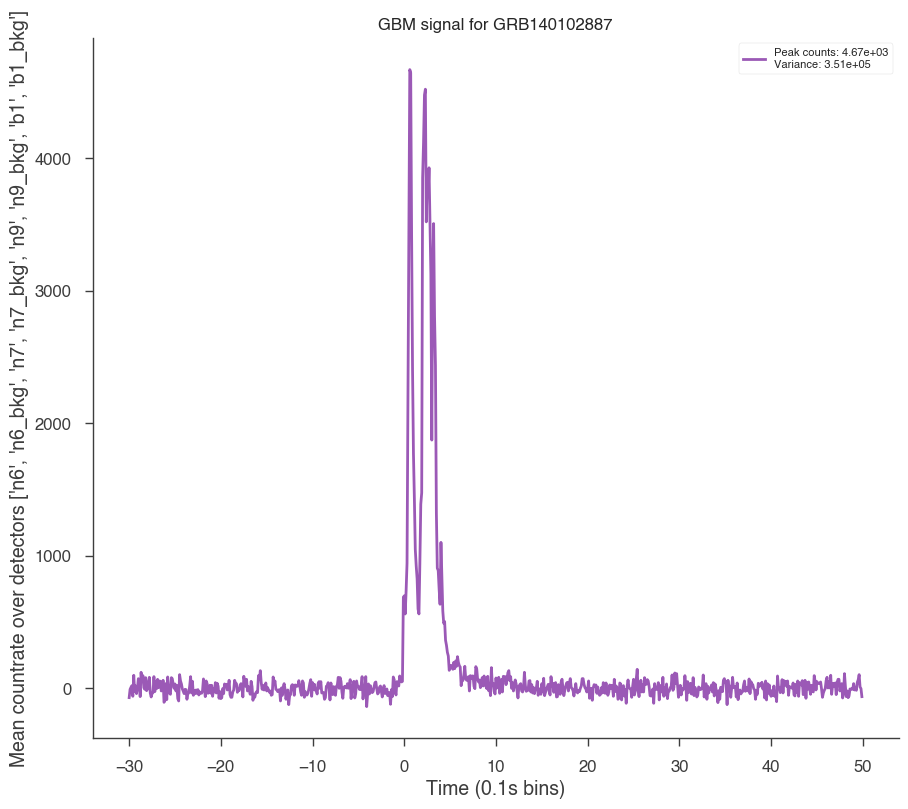

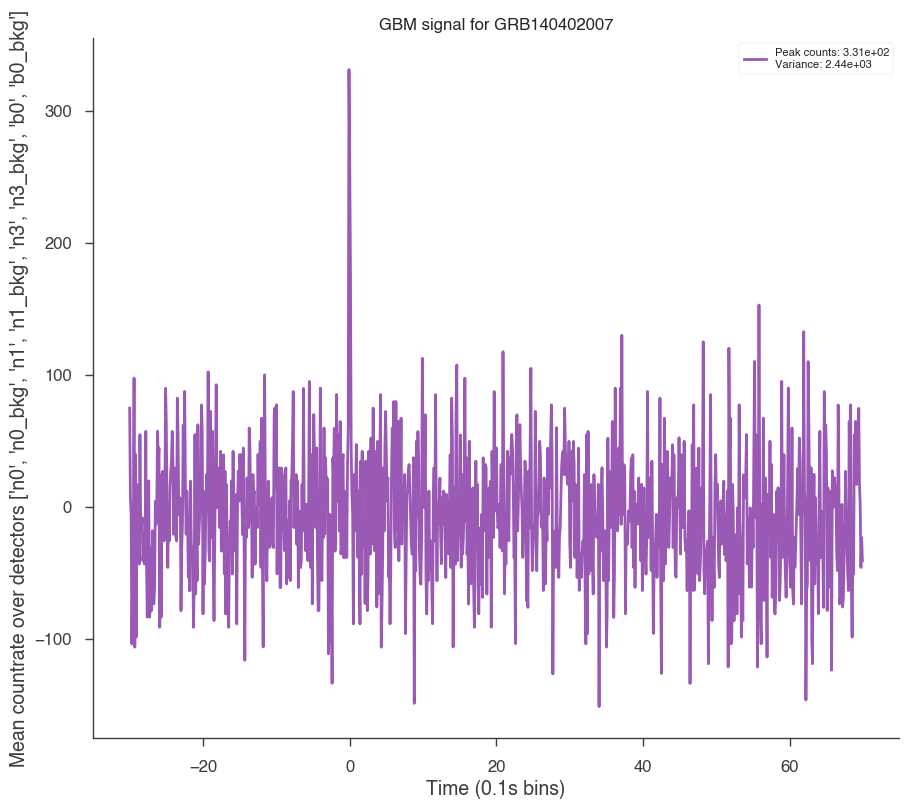

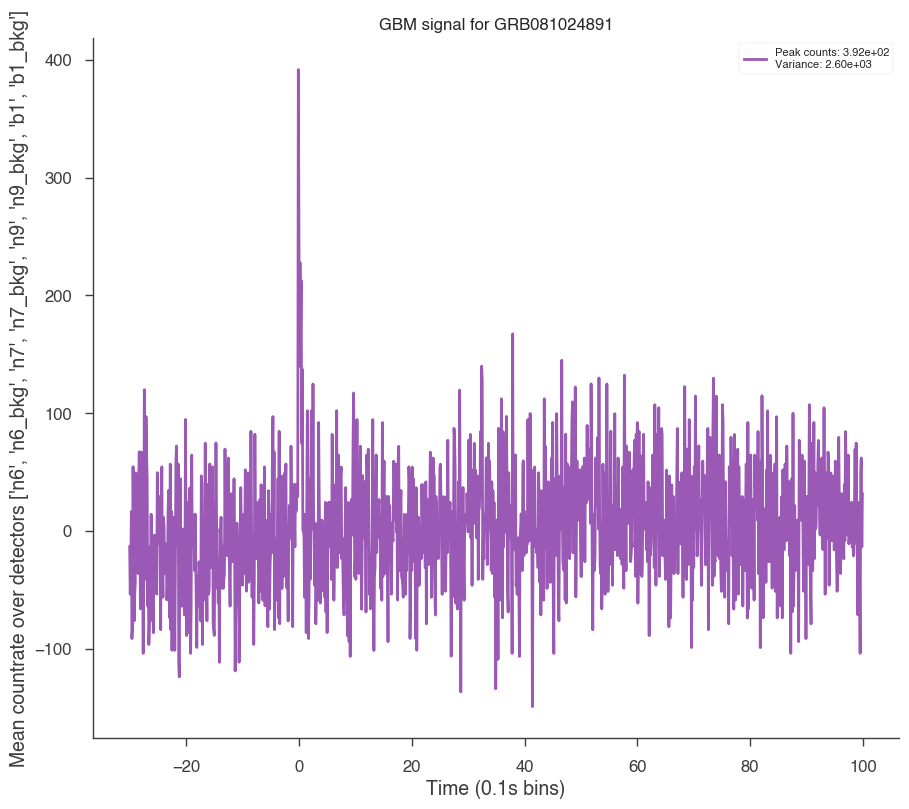

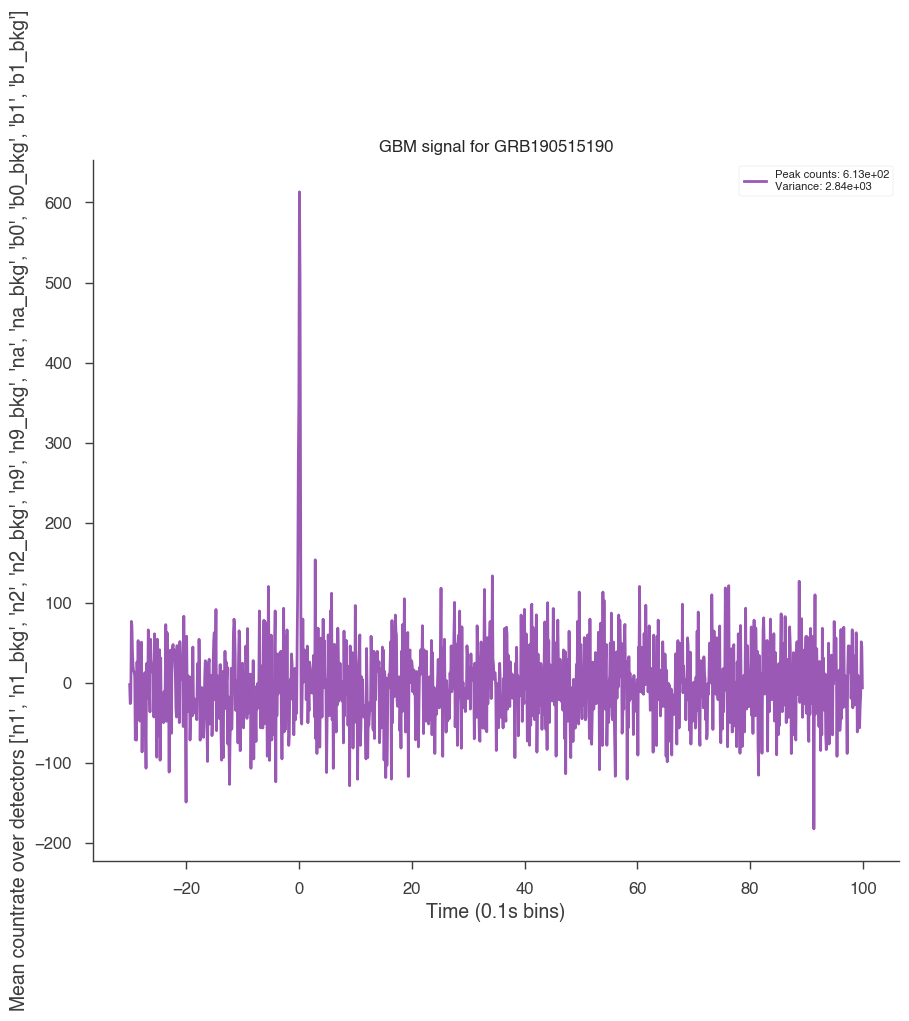

In [5]:
# Generate datasets.
#download_lightcurves()

# Shorter list
selected = pd.read_csv('./../GBM_Catalog_Searching/BOTH_T90_in_[0.2-5].csv')

# Query to list with time_in and time_out
df.query('name in @selected')

dt = 0.1

img_directory = './Selected_GRB_Images/Lightcurves/'
data_directory = './Selected_GRB_Images/Data/'

for i,name in enumerate(selected['name']):
    
    # Load data
    row = df.query('name == @name')
    selected = pd.read_csv('%s%s_%s_to_%s_resolution_%s.csv'%(data_directory, name, 
                                                row['time_in'].iloc[0], row['time_out'].iloc[0], dt))
    
    try:
        # Try data retrieve
        time, data, dets = merge_lightcurves(selected)
    except Exception as e:
        print('Failed for %s, \n%s'%(name, e))
    
    # Create fig
    fig, ax = plt.subplots()
    ax.plot(time, data, label = 'Peak counts: %.2e\nVariance: %.2e'%(data.max(), data.var()))#, s=10)
    #ax.hist(data, nbins=len(time)/10)
    #ax.fill_between(time, data, -1e3)
    ax.set_xlabel('Time (%ss bins)'%dt)
    ax.set_ylabel('Mean countrate over detectors %s'%dets.to_list())
    ax.set_title('GBM signal for %s'%name)
    ax.legend()
    fig.savefig('%s%s.png'%(img_directory, name))
    
    print('Peak flux for %s is %s'%(name, data.max()))
    

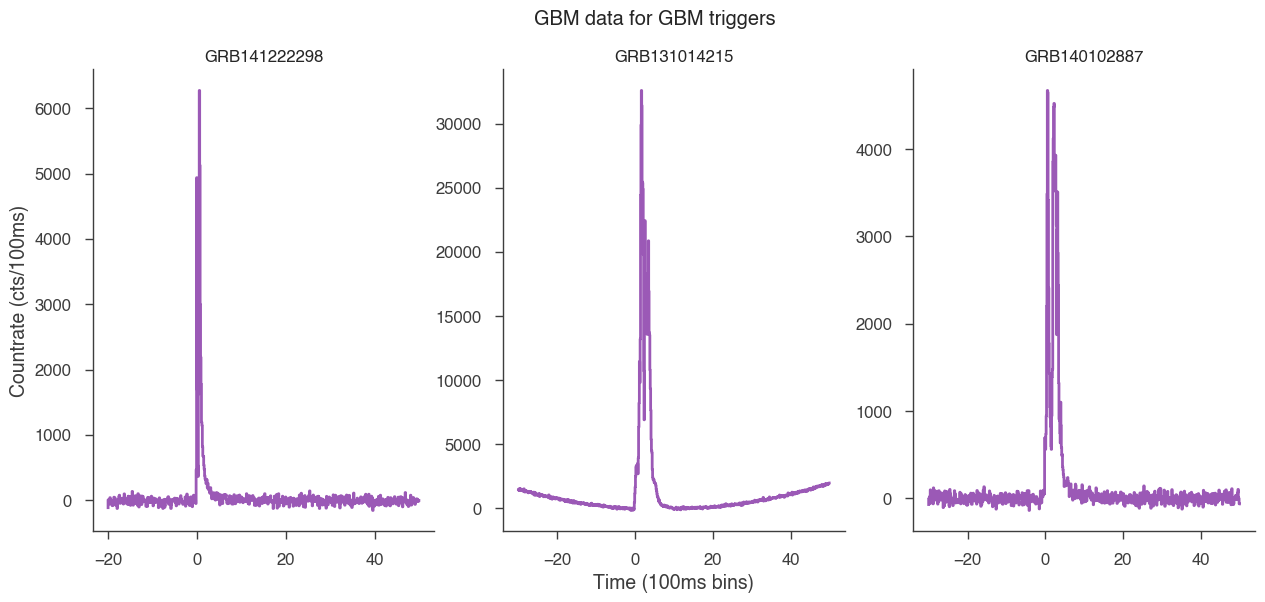

In [109]:
dt = 0.1

img_directory = './Selected_GRB_Images/Lightcurves/'
data_directory = './Selected_GRB_Images/Data/'

names = ['GRB141222298','GRB131014215','GRB140102887']

fig, ax = plt.subplots(1,3)
for i,name in enumerate(names):
    # Load data
    row = df.query('name == @name')
    #print(row)
    selected = pd.read_csv('%s%s_%s_to_%s_resolution_%s.csv'%(data_directory, name, 
                                                row['time_in'].iloc[0], row['time_out'].iloc[0], dt))
    try:
        # Try data retrieve
        time, data, dets = merge_lightcurves(selected)
    except Exception as e:
        print('Failed for %s, \n%s'%(name, e))
        
    ax[i].step(time, data)
    ax[i].set_title('%s'%name)

ax[1].set_xlabel('Time (100ms bins)')
ax[0].set_ylabel('Countrate (cts/100ms)')
fig.set_figwidth(15)
fig.set_figheight(6)

fig.suptitle('GBM data for GBM triggers')
fig.savefig('TopCandidates_GBM.png', dpi=1000)
fig.show()

### Further investigation into the top 3

pre- and after-glow (ag) -- let the fit decide where the afterglow peak is

7-parameter problem: lc_norm, lc_index, lc_location, ag_norm, ag_A, ag_B, ag_delta


normalization should be similar for both lc and ag

check goodness-of-fit of lc without ag to contrast




Stefano is going to use Blackhawc to redo PBH calculations for T90 and Hardness


In [110]:
df = pd.read_csv('./../GBM_Catalog_Searching/BOTH_T90_in_[0.2-5].csv')

data_directory = './Selected_GRB_Images/Data/'

param_names = ['lc_K', 'lc_index', 'lc_delta', 
'ag_K', 'ag_t_m', 'ag_t_p', 'ag_delta']

def lightcurve_model(params):

    # Retrieve new parameters
    (lc_K, lc_index, lc_delta, 
    ag_K, ag_t_m, ag_t_p, ag_delta) = params

    # Instantiate blank model
    model = np.zeros(len(data))

    # Create lc from simplified powerlaw model.
    model = model + simplified_lightcurve(tau = time,
     normalization = lc_K, index = lc_index, delta = lc_delta)

    # Create ag.
    model = model + afterglow(tau=time,
     normalization=ag_K, t_m = ag_t_m, t_p = ag_t_p, delta = ag_delta)

    return model

simplified_model = lambda params: simplified_lightcurve(tau = time, normalization=params[0], index=params[1], delta=params[2])

def likelihood_model(params):
    
    curve = lightcurve_model(params)
    
    like = -0.5 * (((curve - data)/1e2)**2).sum()
    #like = pearsonr(data,curve)[0]
    return like

simple_likelihood_model = lambda params: -0.5*(((simplified_model(params)-data)/np.mean(data)*.1)**2).sum()

In [113]:
GRBNAME = 'GRB141222298'

# GRB info
select = df.query('name == @GRBNAME')
time_in = select['time_in'].iloc[0]
time_out = select['time_out'].iloc[0]
#dets = select['detectors'].iloc[0]

# Choose resolution & retrieve data
dt = 0.1
selected = pd.read_csv('%s%s_%s_to_%s_resolution_%s.csv'%(data_directory, GRBNAME, time_in, time_out, dt))

# Use the following as global variables.
time, data, dets = merge_lightcurves(selected)
peak_index = list(data).index(max(data))

# Let's narrow down the band of the signal ( by selecting the T90? )
in_index = list(time).index(-1)
out_index = list(time).index(4)
time = time[in_index:out_index]
data = data[in_index:out_index]

# Create Likelihood evaluation fcn.
poisson_likelihood_model = lambda params: -0.5 * ((
    (lightcurve_model(params) - data)
    /(0.5*data)) **2).sum()

# Define priors.
def prior_1412(cube):
    params = cube.copy()
    
    # lc_K: uniform
    lo = 1000
    hi = 1500
    params[0] = cube[0] * (hi - lo) + lo

    # lc_index: gaussian on -.52 
    hi = .9
    lo = .4
    params[1] = cube[1] * (hi - lo) + lo

    # lc_delta: gaussian on the time w peak index
    hi = .2
    lo = -.1
    params[2] = cube[2] * (hi - lo) + lo
    
    # ag_K: uniform
    lo = 7*1e3
    hi = 1e4
    params[3] = cube[3] * (hi - lo) + lo
    
    # ag_t_m: uniform
    lo = 1e-3
    hi = 1e-1
    params[4] = cube[4] * (hi - lo) + lo
    
    # ag_t_p: uniform
    lo = params[4]
    hi = .7 # t_p > t_m
    params[5] = cube[5] * (hi - lo) + lo
    
    # ag_delta: uniform
    hi = .7
    lo = 0
    params[2] = cube[2] * (hi - lo) + lo
    
    return params

def prior_simple(cube):
    params = cube.copy()

    # lc_K: uniform
    lo = 1e2
    hi = 1e4
    params[0] = cube[0] * (hi - lo) + lo

    # lc_index: gaussian on -.52 
    params[1] = norm.ppf(cube[1], .52, 1)

    # lc_delta: gaussian on the time w peak index
    params[2] = norm.ppf(cube[1], -time[peak_index], 1)

    return params

#param_names = ['lc_K', 'lc_index', 'lc_delta']

In [115]:
sampler = ultranest.ReactiveNestedSampler(param_names, poisson_likelihood_model, prior_1412)#simple_likelihood_model, prior_simple)#

result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


KeyboardInterrupt: 

0.7134216172757318


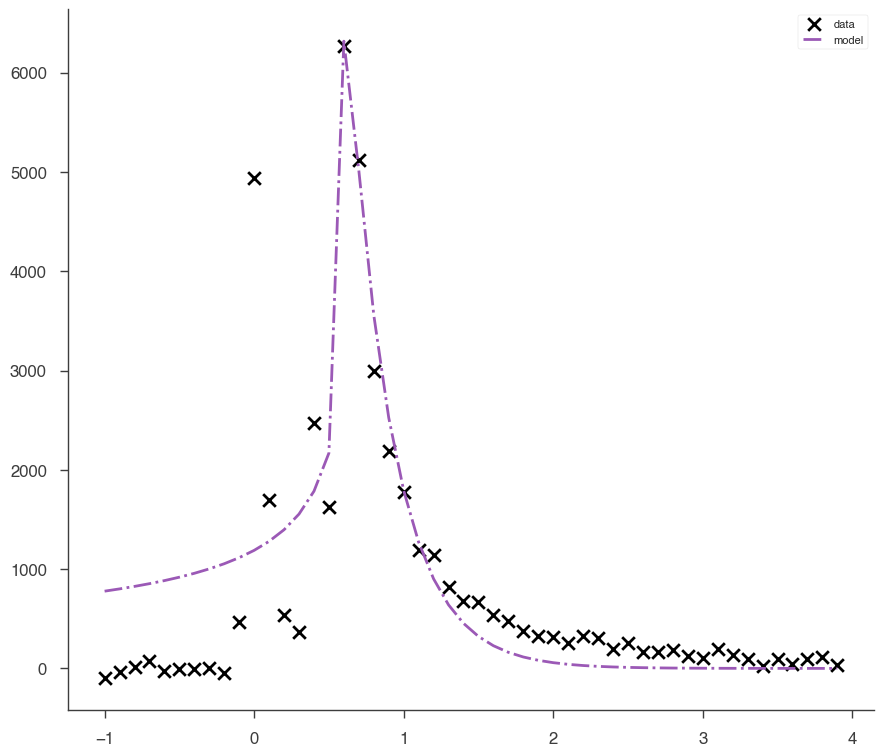

In [18]:
fig, ax = plt.subplots()

ax.scatter(time, data, marker='x', label='data', color='black')

params = (
    #1253, .63, .1, 9500, .051, .35, .5
    1001.6, .477, .6979, 7039, .0091, .2914, .6013
)

model = lightcurve_model(params)
#model = simplified_lightcurve(tau = time, normalization=1218, index=.52, delta=-.74)

ax.plot(time, model, '-.', label='model')
ax.legend()

print(r2_score(data, model))

In [19]:
GRBNAME = 'GRB131014215'

# GRB info
select = df.query('name == @GRBNAME')
time_in = select['time_in'].iloc[0]
time_out = select['time_out'].iloc[0]
#dets = select['detectors'].iloc[0]

# Choose resolution & retrieve data
dt = 0.1
selected = pd.read_csv('%s%s_%s_to_%s_resolution_%s.csv'%(data_directory, GRBNAME, time_in, time_out, dt))

# Use the following as global variables.
time, data, dets = merge_lightcurves(selected)
peak_index = list(data).index(max(data))

# Let's narrow down the band of the signal ( by selecting the T90? )
in_index = list(time).index(-1)
out_index = list(time).index(8)
time = time[in_index:out_index]
data = data[in_index:out_index]

# Define priors.
def prior_1310(cube):
    params = cube.copy()
    
    # lc_K: uniform
    lo = 1000
    hi = 5000
    params[0] = cube[0] * (hi - lo) + lo

    # lc_index: gaussian on -.52 
    hi = .9
    lo = .4
    params[1] = cube[1] * (hi - lo) + lo

    # lc_delta: gaussian on the time w peak index
    hi = 2
    lo = 1
    params[2] = cube[2] * (hi - lo) + lo
    
    # ag_K: uniform
    lo = 1e5
    hi = 1e4
    params[3] = cube[3] * (hi - lo) + lo
    
    # ag_t_m: uniform
    lo = 1e-3
    hi = 1e-1
    params[4] = cube[4] * (hi - lo) + lo
    
    # ag_t_p: uniform
    lo = params[4]
    hi = 2 # t_p > t_m
    params[5] = cube[5] * (hi - lo) + lo
    
    # ag_delta: uniform
    hi = 2
    lo = 1
    params[2] = cube[2] * (hi - lo) + lo
    
    return params

In [10]:
sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_1310)#simple_likelihood_model, prior_simple)#

result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+05  -99120.20 [-99121.2268..-99121.2263]*| it/evals=26680/332269 eff=8.0393% N=400    
[ultranest] Likelihood function evaluations: 332276
[ultranest]   logZ = -9.918e+04 +- 0.3171
[ultranest] Effective samples strategy satisfied (ESS = 3582.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.27 to 0.69, need <0.5)
[ultranest]   logZ error budget: single: 0.38 bs:0.32 tail:0.01 total:0.32 required:<0.50
[ultranest] done iterating.

logZ = -99183.069 +- 0.694
  single instance: logZ = -99183.069 +- 0.379
  bootstrapped   : logZ = -99183.064 +- 0.694
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    lc_K                : 1000.00│▇▆▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁ ▁    ▁ │1002.57    1000.21 +- 0.21
    lc_index            : 0.89498│ ▁  ▁▁ ▁ ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂

0.7021865837985328


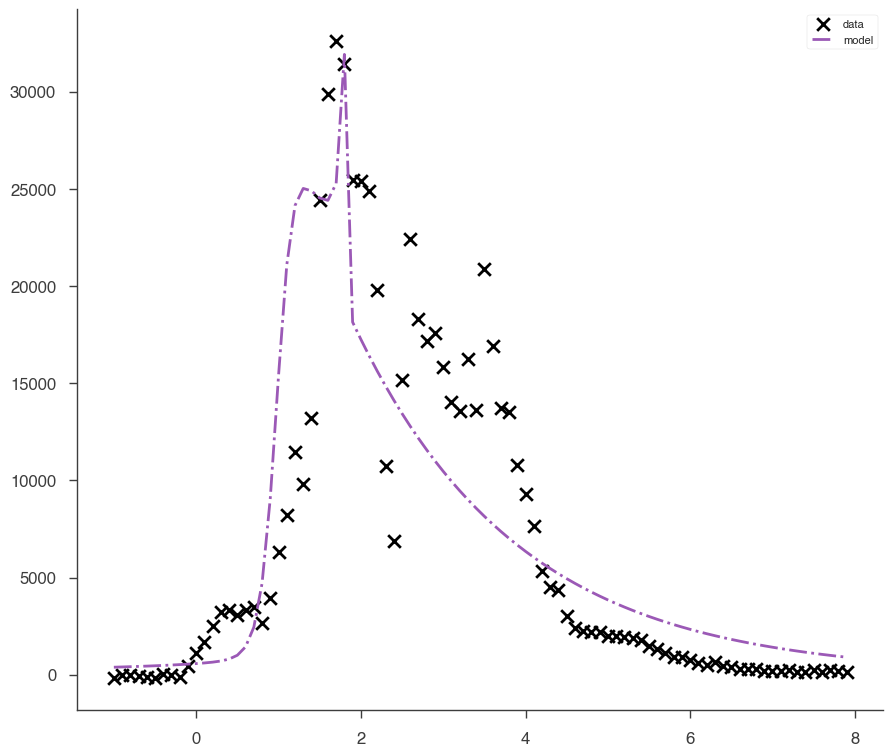

In [20]:
fig, ax = plt.subplots()

ax.scatter(time, data, marker='x', label='data', color='black')

params = (
    #3500, .7, 1.8, 3.5*1e4, .1, 1.3, 1.7
    1000.21, .89953, 1.85853, 28460, .0999944, 1.999973, .999954
)

model = lightcurve_model(params)
#model = simplified_lightcurve(tau = time, normalization=1218, index=.52, delta=-.74)

ax.plot(time, model, '-.', label='model')
ax.legend()

print(r2_score(data, model))

In [60]:
GRBNAME = 'GRB140102887'

# GRB info
select = df.query('name == @GRBNAME')
time_in = select['time_in'].iloc[0]
time_out = select['time_out'].iloc[0]
#dets = select['detectors'].iloc[0]

# Choose resolution & retrieve data
dt = 0.1
selected = pd.read_csv('%s%s_%s_to_%s_resolution_%s.csv'%(data_directory, GRBNAME, time_in, time_out, dt))

# Use the following as global variables.
time, data, dets = merge_lightcurves(selected)
peak_index = list(data).index(max(data))

# Let's narrow down the band of the signal ( by selecting the T90? )
in_index = list(time).index(-2)
out_index = list(time).index(8)
time = time[in_index:out_index]
data = data[in_index:out_index]

# Define priors.
def prior_1401(cube):
    params = cube.copy()
    
    # lc_K: uniform
    lo = 500
    hi = 2000
    params[0] = cube[0] * (hi - lo) + lo

    # lc_index: gaussian on -.52 
    lo = .4
    hi = .9
    params[1] = cube[1] * (hi - lo) + lo

    # lc_delta: gaussian on the time w peak index
    lo = .6
    hi = .9
    params[2] = cube[2] * (hi - lo) + lo
    
    # ag_K: uniform
    lo = 1e2
    hi = 1e4
    params[3] = cube[3] * (hi - lo) + lo
    
    # ag_t_m: uniform
    lo = 1e-3
    hi = .3
    params[4] = cube[4] * (hi - lo) + lo
    
    # ag_t_p: uniform
    lo = params[4]
    hi = 1 # t_p > t_m
    params[5] = cube[5] * (hi - lo) + lo
    
    # ag_delta: uniform
    hi = 2.5
    lo = 2
    params[2] = cube[2] * (hi - lo) + lo
    
    return params

In [91]:
sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_model, prior_1401)

result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-6e+03  094.35 [-6095.0291..-6095.0290]*| it/evals=15430/230938 eff=6.6930% N=400 
[ultranest] Likelihood function evaluations: 230939
[ultranest]   logZ = -6129 +- 0.1963
[ultranest] Effective samples strategy satisfied (ESS = 3169.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.17 to 0.50, need <0.5)
[ultranest]   logZ error budget: single: 0.27 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.

logZ = -6128.810 +- 0.502
  single instance: logZ = -6128.810 +- 0.274
  bootstrapped   : logZ = -6128.744 +- 0.502
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    lc_K                : 500   │▁▁▁▁▂▂▂▃▄▅▆▆▇▇▇▇▆▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁  ▁▁ │597       536 +- 12
    lc_index            : 0.8319│ ▁        ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▅▆▇│0.9000    0.8922 +-

0.6


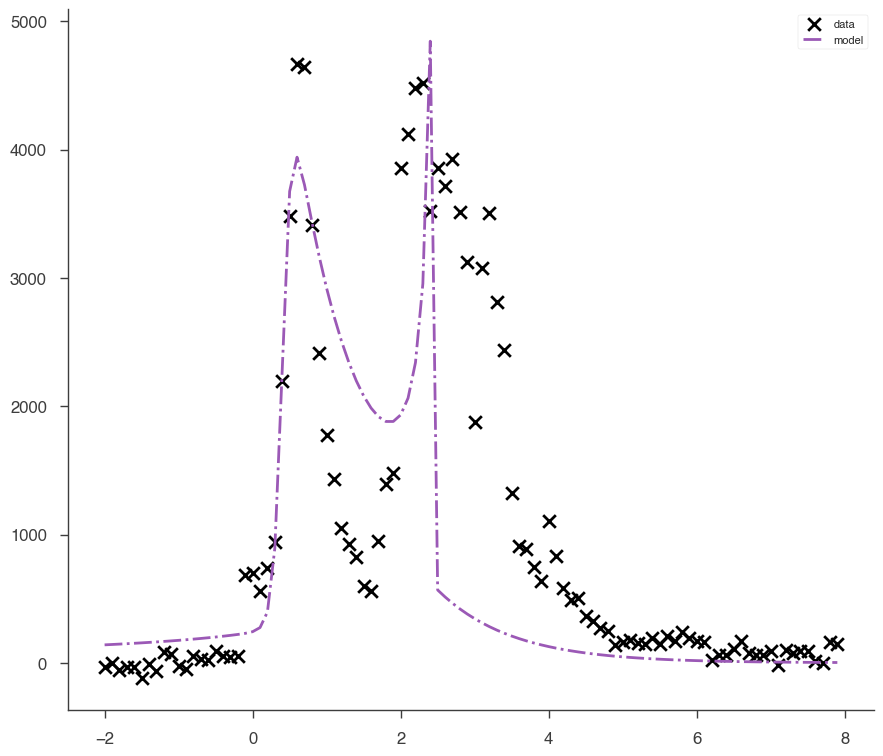

In [61]:
fig, ax = plt.subplots()

ax.scatter(time, data, marker='x', label='data', color='black')

params = (
    #1000, .7, .8, 8800, .2, .6, 2.3
    536, .892, 2.499, 4566, .0589, .9995, .4159
)

model = lightcurve_model(params)
#model = simplified_lightcurve(tau = time, normalization=1218, index=.52, delta=-.74)

ax.plot(time, model, '-.', label='model')
ax.legend()
print(time[peak_index])

### This one also seems good?

#### <a id="09" style="color:black;">bn0901031500</a>

- tau = [ -30 , 60 ]

- K_lightcurve = [ 10 , 1e5 ]
- K_powerlaw = [ 1 , 1e4 ]

['n9']


03:32:06 INFO      file glg_cspec_n9_bn130310840_v00.pha is already downloaded!           ]8;id=546077;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=302225;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

         INFO      file glg_cspec_n9_bn130310840_v03.rsp is already downloaded!           ]8;id=822513;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=171863;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

03:32:07 INFO      file glg_tte_n9_bn130310840_v00.fit is already downloaded!             ]8;id=977921;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py\download_from_http.py]8;;\:]8;id=676357;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/io/download_from_http.py#195\195]8;;\

Loading PHAII Spectra:   0%|                           | 0/1854 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|                      | 0/5 [00:00<?, ?it/s]

03:32:10 INFO      Auto-determined polynomial order: 0                                ]8;id=799622;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=317703;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/binned_spectrum_series.py#391\391]8;;\

Fitting GBM_NAI_09 background:   0%|                    | 0/128 [00:00<?, ?it/s]

03:32:22 INFO      None 0-order polynomial fit with the mle method                               ]8;id=236388;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=20192;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#459\459]8;;\

         INFO      Saved fitted background to n9_bkg.h5                                         ]8;id=688154;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=534488;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n9_bkg.h5                                         ]8;id=582310;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=248407;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n9_bkg.h5                              ]8;id=476640;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=425196;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 4.096-20.096 for n9                                   ]8;id=974628;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=768039;file:///Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/threeML/utils/data_builders/time_series_builder.py#291\291]8;;\

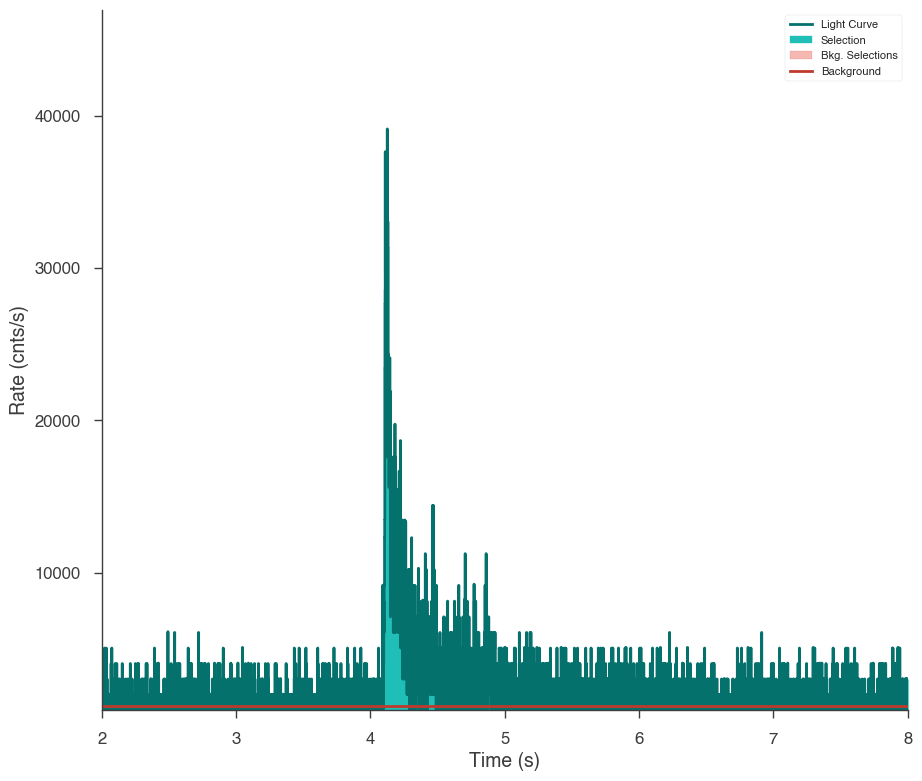

In [14]:
GRBNAME = '130310840'

figures = query_catalog(GRBNAME = GRBNAME, 
                        time_in = 2, time_out = 8, dt=1e-3,
                        gbm_detectors = ['n9'])

Text(0.5, 0, 's')

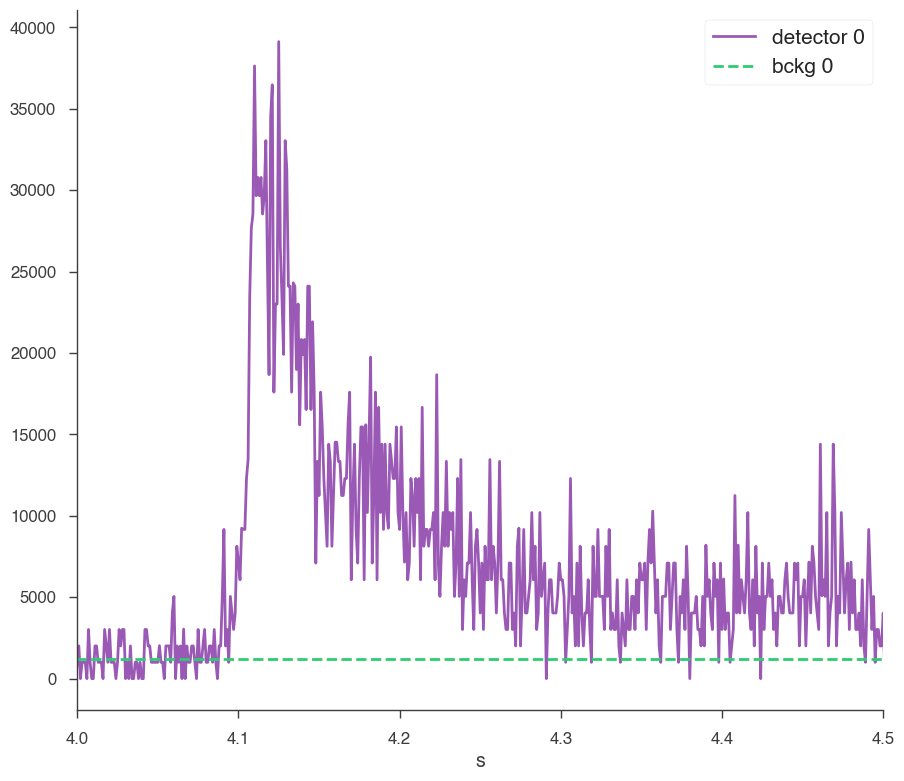

In [15]:
fig = show_curves(figures)
ax = fig.get_axes()[0]
ax.set_xlim(4,4.5)
ax.set_xlabel('s')
# Looks quite similar to Figure 5 in the Cline '97 paper

In [33]:
def prior_transform_13(cube):
    params = cube.copy()

    # K_lightcurve: uniform
    lo = 1e3
    hi = 1e5
    params[0] = cube[0] * (hi - lo) + lo
    """
    # K_powerlaw: uniform
    lo = 1
    hi = 1e4
    params[1] = cube[1] * (hi - lo) + lo
    
    # t_m_powerlaw: uniform
    lo = 1e-3
    hi = 1e3
    params[2] = cube[2] * (hi - lo) + lo
    
    # t_p_powerlaw: uniform
    lo = 1e-3
    hi = 1e3 # t_p < t_m
    params[3] = cube[3] * (hi - lo) + lo
    
    # delta_powerlaw: uniform
    lo = -20
    hi = 60
    params[4] = cube[4] * (hi - lo) + lo
    """
    # index_lightcurve: gaussian on -.52 
    params[1] = norm.ppf(cube[1], -.52, 1)
    
    return params

data, time_domain = retrieve_data(figures)

In [34]:
bckg_data=[]
for fig in figures:
    _,_, b = get_curves(fig)
    bckg_data.append(b)
error_tolerance = 1e2#np.std(bckg_data)
print('Using error tolerance of %3e'%error_tolerance)

peak_index = np.where(data == max(data))[0][0]
print('Peak index at %s'%peak_index)

sampler = ultranest.ReactiveNestedSampler([param_names[0], param_names[-1]],
                                          likelihood_model_only_direct, prior_transform_13)

result19 = sampler.run()
sampler.print_results()

Using error tolerance of 1.000000e+02
Peak index at 2125
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+06  91..-2297783.90 [-2297783.9135..-2297783.9135]*| it/evals=7840/10603 eff=76.8401% N=400 
[ultranest] Likelihood function evaluations: 10617
[ultranest]   logZ = -2.298e+06 +- 0.1394
[ultranest] Effective samples strategy satisfied (ESS = 1590.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.

logZ = -2297798.935 +- 0.342
  single instance: logZ = -2297798.935 +- 0.187
  bootstrapped   : logZ = -2297798.947 +- 0.342
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    K_lightcurve        : 47352 │ ▁▁▁▁▁▁▁▁▂▃▃▄▆▅▅▆▆▇▇▆▅▅▃▃▂▁▂▁▁▁▁▁▁▁▁ ▁ │47913     47610 +- 70
    index_lightcurve    : 0.69056│ ▁▁▁▁▁▁▁▁▁▂▂▂▃▄▆▅▆▇▇▇▇▆▇▅▄▄▂▂▂▁▁▁▁▁▁▁▁ │0.69469    0.69272 

In [ ]:
df = pd.read_csv('./../GBM_Catalog_Searching/BOTH_T90_in_[0.2-5].csv')

df['detectors'] = [['n0','n1','n3','b0'],
                   ['n9','na','nb','b1'],
                   ['n6','n9','b1'], # omits na which has that awful bkg fit
                   ['n6','n7','n9', 'b1'],
                   ['n0','n1','n3','b0'],
                   ['n6','n7','n9','b1'],
                   ["n1","n2","n9","na","b0","b1"]]
df.to_csv('./../GBM_Catalog_Searching/BOTH_T90_in_[0.2-5].csv')

df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,name,ra,dec,hardness,lle_t90,gbm_cat_t90,gbm-lle_t90_difference,time_in,time_out,detectors
0,0,2,25,GRB141222298,178.00,-57.31,inf,1.293,2.752,1.459,-20.0,50.0,"[n0, n1, n3, b0]"
1,1,16,85,GRB131014215,100.78,-20.76,1.224058,1.811,3.200,1.389,-30.0,50.0,"[n9, na, nb, b1]"
2,2,18,100,GRB140619475,132.66,-9.65,1.339559,1.124,2.816,1.692,-30.0,100.0,"[n6, n9, b1]"
3,3,21,121,GRB140102887,212.02,1.47,1.319773,2.872,3.648,0.776,-30.0,50.0,"[n6, n7, n9, b1]"
4,4,24,131,GRB140402007,207.66,5.97,9.669260,1.546,0.320,-1.226,-30.0,70.0,"[n0, n1, n3, b0]"
5,5,30,155,GRB081024891,323.01,20.84,1.916036,1.320,0.640,-0.680,-30.0,100.0,"[n6, n7, n9, b1]"
6,6,31,168,GRB190515190,137.75,28.93,1.454990,1.645,1.264,-0.381,-30.0,100.0,"[n1, n2, n9, na, b0, b1]"


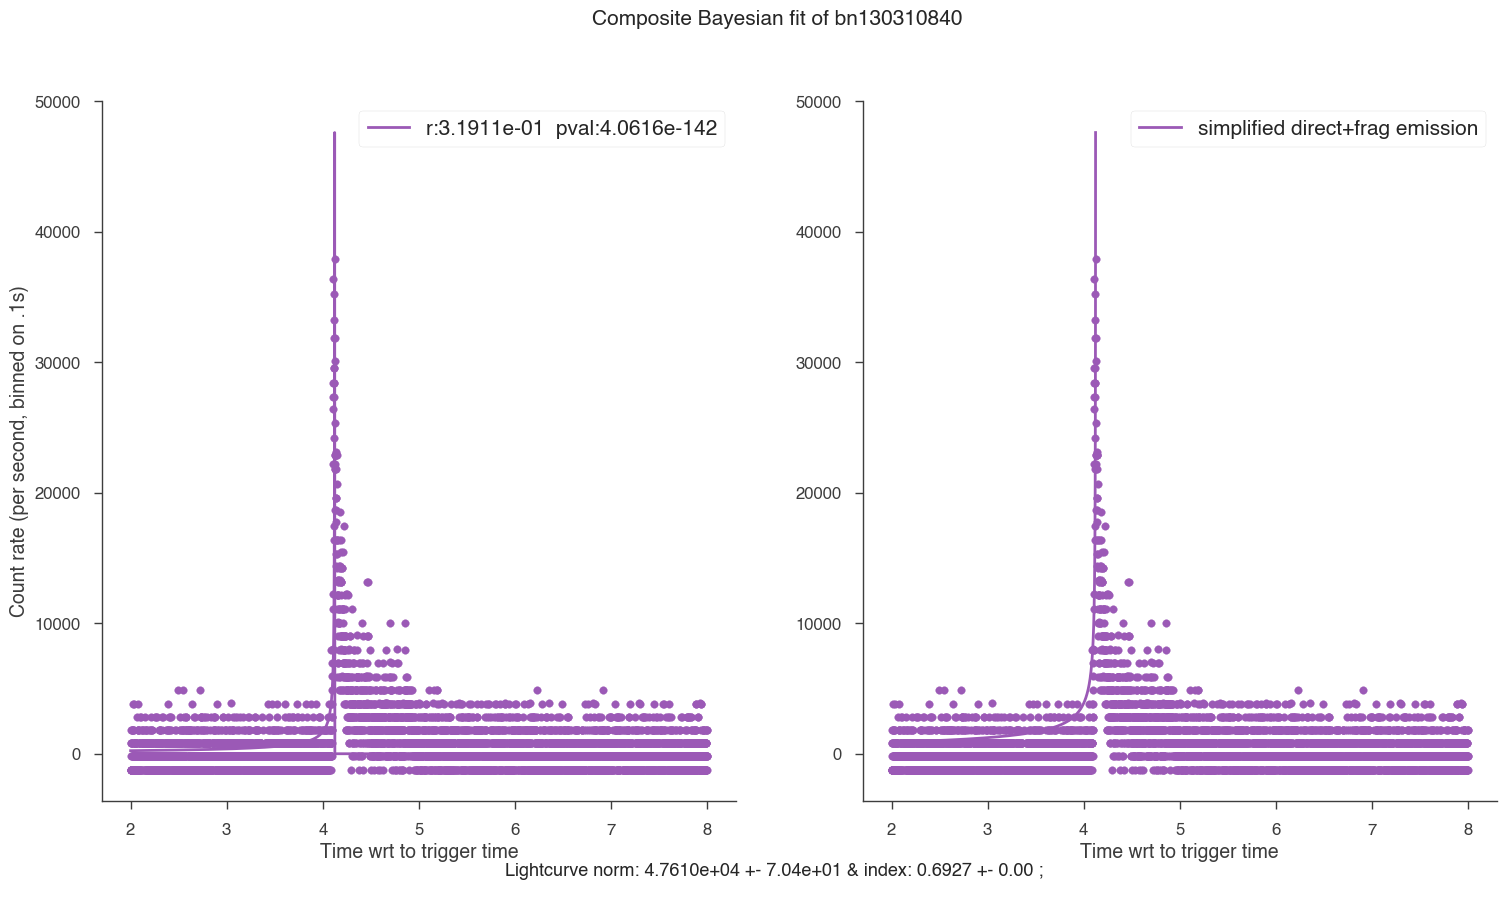

In [52]:
v = result19['posterior']['mean']
s = result19['posterior']['stdev']
fig = plot_model(time_domain, vals = [v[0], None, None, None, None, v[1]], log=False, name='bn130310840',
                fig_text = "Lightcurve norm: %.4e +- %.2e & index: %.4f +- %.2f ; \n"%(v[0], s[0], v[1], s[1]))


----
### <a id="dl_sp" style="color:black;">Downloading spectra</a>
[back to top](#Top)

Generating spectrum for the sources with HS>1, gbm AND lle t90 in (0.2,5) and RS=0

[SpectrumLike spectrum gen](https://threeml.readthedocs.io/en/stable/notebooks/spectrum_tutorial.html)

In [21]:
df = pd.read_csv('./../GBM_Catalog_Searching/BOTH_T90_in_[0.2-5].csv')
df

,Unnamed: 0,Unnamed: 0.1,name,ra,dec,hardness,lle_t90,gbm_cat_t90,gbm-lle_t90_difference,time_in,time_out
0,2,25,GRB141222298,178.00,-57.31,inf,1.293,2.752,1.459,-20.0,50.0
1,16,85,GRB131014215,100.78,-20.76,1.224058,1.811,3.200,1.389,-30.0,50.0
2,18,100,GRB140619475,132.66,-9.65,1.339559,1.124,2.816,1.692,-30.0,100.0
3,21,121,GRB140102887,212.02,1.47,1.319773,2.872,3.648,0.776,-30.0,50.0
4,24,131,GRB140402007,207.66,5.97,9.669260,1.546,0.320,-1.226,-30.0,70.0
5,30,155,GRB081024891,323.01,20.84,1.916036,1.320,0.640,-0.680,-30.0,100.0
6,31,168,GRB190515190,137.75,28.93,1.454990,1.645,1.264,-0.381,-30.0,100.0


In [82]:
location='./Selected_GRB_Images/Spectra/'

def generate_spectrum(GRBNAME):
    """
    Generate spectrum images for the detectors of a given GRB.

    Returns list of figures with spectra for each detector.
    """
    gbm_catalog.query_sources(GRBNAME)

    grb_info = gbm_catalog.get_detector_information()[GRBNAME]

    gbm_detectors = grb_info["detectors"]
    if len(gbm_detectors) < 1:
        gbm_detectors = ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'na','nb', 'b0', 'b1']
    print(gbm_detectors)
    
    source_interval = grb_info["source"]["fluence"]
    background_interval = grb_info["background"]["full"]
    #best_fit_model = grb_info["best fit model"]["fluence"]
    #model = gbm_catalog.get_model(best_fit_model, "fluence")[GRBNAME]

    dload = download_GBM_trigger_data('bn%s'%GRBNAME[3:], detectors=gbm_detectors)

    figs = []
    #fluence_plugins = []
    time_series = {}
    figures = []
    for det in gbm_detectors:

        ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
            det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
        )

        ts_cspec.set_background_interval(*background_interval.split(","))
        ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

        ts_tte = TimeSeriesBuilder.from_gbm_tte(
            det,
            tte_file=dload[det]["tte"],
            rsp_file=dload[det]["rsp"],
            restore_background=f"{det}_bkg.h5",
        )

        time_series[det] = ts_tte

        ts_tte.set_active_time_interval(source_interval)

        #figures.append(ts_tte.view_lightcurve(-40, 100))

        fluence_plugin = ts_tte.to_spectrumlike()

        if det.startswith("b"):

            fluence_plugin.set_active_measurements("250-30000")

        else:

            fluence_plugin.set_active_measurements("9-900")

        fluence_plugin.rebin_on_background(1.0)

        fig = fluence_plugin.view_count_spectrum()
        fig.suptitle('%s Detector %s'%(GRBNAME, det))
        
        fig.savefig('%s%s_det_%s'%(location, GRBNAME, det))

        figs.append( fig )

        #fluence_plugins.append(fluence_plugin)

In [ ]:
for name in ["GRB190515190"]:#df['name']:
    try:
        generate_spectrum(name)
    except Exception as e:
        print('Failed with %s\n%s'%(name, e))